<a href="https://colab.research.google.com/github/Jonaminio/Analise_credito_kaggle/blob/main/Gato_ou_Cachorro_KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial keras: https://keras.io/examples/vision/image_classification_from_scratch/

## KERAS

Configurar

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Carregue os dados: o conjunto de dados Cats vs Dogs

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   284M      0  0:00:02  0:00:02 --:--:--  284M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


Agora temos uma PetImagespasta que contém duas subpastas Cate Dog. Cada subpasta contém arquivos de imagem para cada categoria.

In [ ]:
!ls PetImages

Cat  Dog


Filtre imagens corrompidas

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


Gere umDataset

In [ ]:
#tamanho da imagem
#image_size = (180, 180)
image_size = (80, 80)
#quantas imagens tarbalhar a cada epoca
batch_size = 100
#batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Visualize os dados

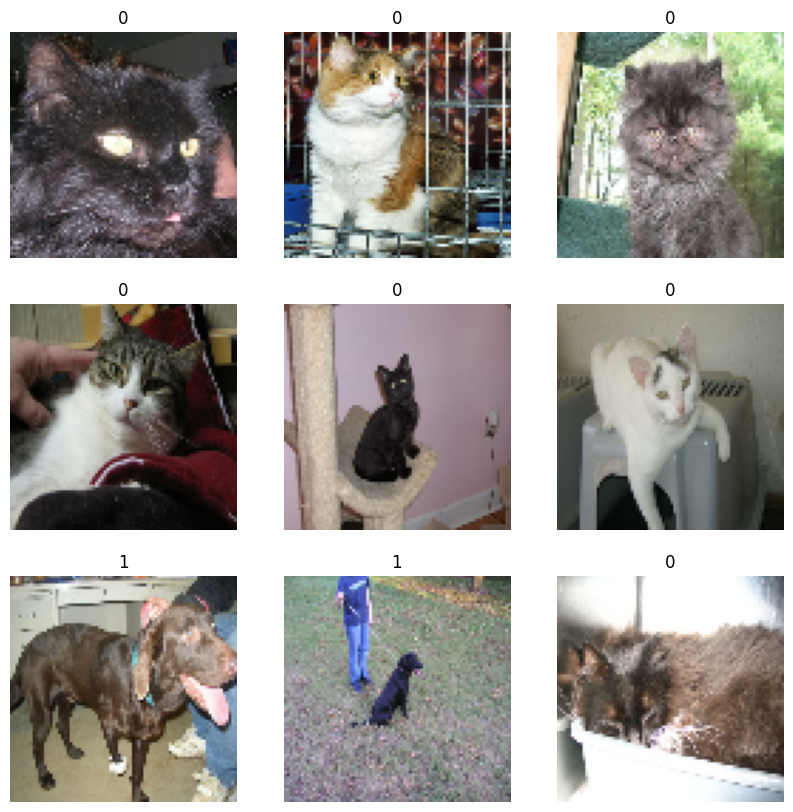

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

vendo imagem como matriz

In [ ]:
images[0].numpy().astype("uint8")

array([[[ 33,  37,  36],
        [ 32,  36,  35],
        [ 34,  38,  35],
        ...,
        [ 60,  65,  71],
        [ 59,  64,  69],
        [ 57,  62,  66]],

       [[ 30,  34,  33],
        [ 31,  35,  34],
        [ 31,  35,  33],
        ...,
        [ 61,  66,  70],
        [ 51,  56,  60],
        [ 56,  61,  65]],

       [[ 30,  35,  32],
        [ 31,  35,  32],
        [ 31,  35,  32],
        ...,
        [ 51,  56,  59],
        [ 58,  65,  73],
        [ 42,  49,  58]],

       ...,

       [[ 99,  93, 102],
        [ 62,  55,  62],
        [ 92,  83,  88],
        ...,
        [ 29,  25,  26],
        [ 35,  31,  30],
        [ 30,  26,  23]],

       [[115, 110, 117],
        [116, 110, 115],
        [108,  99, 105],
        ...,
        [ 47,  43,  44],
        [ 27,  23,  22],
        [ 25,  21,  18]],

       [[ 38,  37,  41],
        [ 47,  38,  45],
        [ 80,  76,  81],
        ...,
        [ 25,  21,  20],
        [ 30,  26,  26],
        [ 19,  15,  12]]

####Usando aumento de dados de imagem
Quando você não tem um grande conjunto de dados de imagens, é uma boa prática introduzir artificialmente a diversidade de amostras aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como inversão horizontal aleatória ou pequenas rotações aleatórias. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento, ao mesmo tempo que retarda o overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Vizualizando

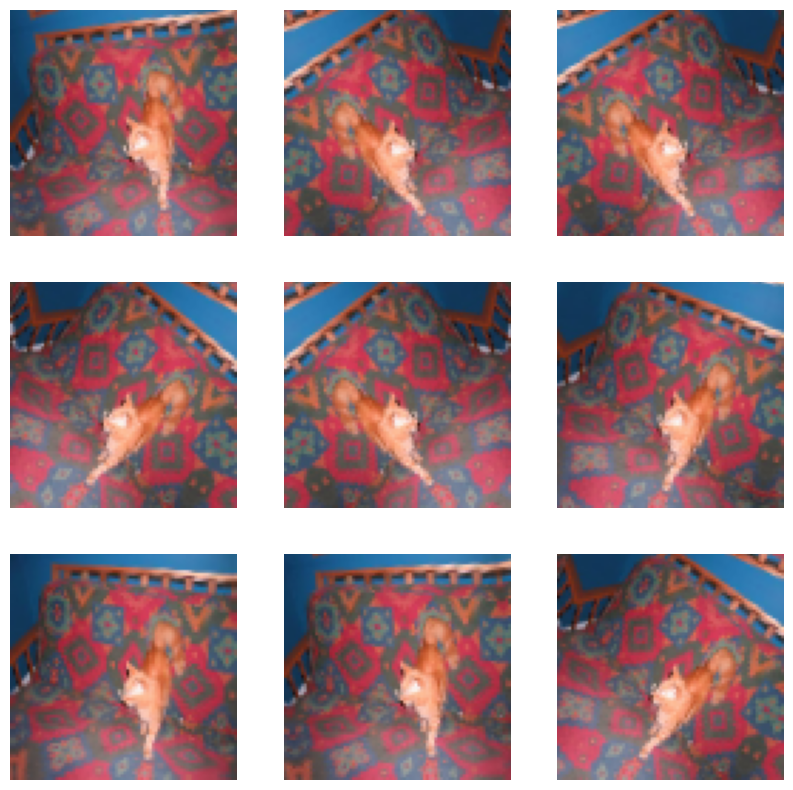

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

###Padronizando os dados
Nossas imagens já estão em tamanho padrão (180x180), pois estão sendo produzidas em float32lotes contíguos por nosso conjunto de dados. No entanto, os valores dos canais RGB estão dentro do [0, 255]intervalo. Isto não é ideal para uma rede neural; em geral, você deve tentar diminuir os valores de entrada. Aqui, padronizaremos os valores [0, 1]usando uma Rescalingcamada no início do nosso modelo.

para GPU

In [ ]:
#inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)
#...  # Rest of the model

para CPU

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

###Configure o conjunto de dados para desempenho
Vamos aplicar o aumento de dados ao nosso conjunto de dados de treinamento e usar a pré-busca em buffer para que possamos gerar dados do disco sem que a E/S se torne um bloqueio:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

###Construir um modelo
Construiremos uma versão pequena da rede Xception. Não tentamos particularmente otimizar a arquitetura; se você quiser fazer uma busca sistemática pela melhor configuração do modelo, considere usar KerasTuner .

Observe que:

Iniciamos o modelo com o data_augmentationpré-processador, seguido de uma Rescalingcamada.
Incluímos uma Dropoutcamada antes da camada de classificação final.

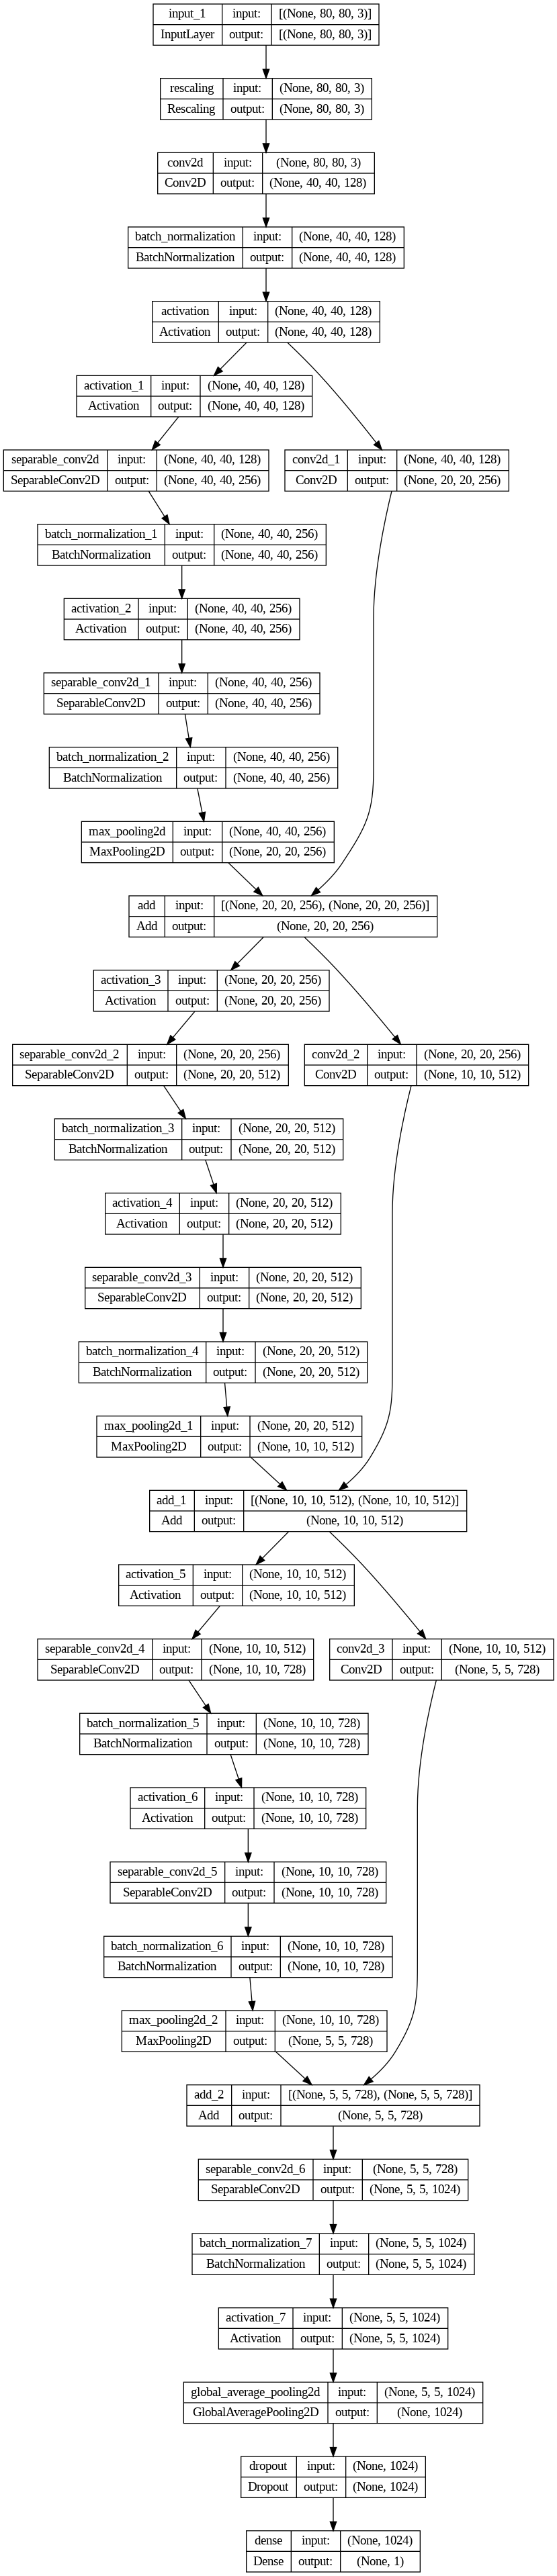

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    #cogulação
    #128 = numeros de
    #3 = tamanho da matriz
    #strides tamanho do pulo
    #padding quando a matriz da um pulo ela preenche
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    # sigmoind bom pra binario
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    #unitis finais tem que ser correspondente ao numero de classes, sou seja cat ou dog, seria 1
    #units numero de neuronimos
    #camada densa 1 com numero de neuromios aletorios (onde está?)
    #camada desna 2 com numero iguais ao de classes
    #essa abaixo seria a camada densa 2
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

###Treine o modelo

In [ ]:
epochs = 12

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)
historico = model.history.history

Epoch 1/12
188/188 [==============================] - 66s 239ms/step - loss: 0.6001 - accuracy: 0.6862 - val_loss: 0.7003 - val_accuracy: 0.4957
Epoch 2/12
188/188 [==============================] - 45s 233ms/step - loss: 0.4592 - accuracy: 0.7847 - val_loss: 0.8100 - val_accuracy: 0.4957
Epoch 3/12
188/188 [==============================] - 42s 219ms/step - loss: 0.3700 - accuracy: 0.8332 - val_loss: 0.8173 - val_accuracy: 0.5765
Epoch 4/12
188/188 [==============================] - 43s 227ms/step - loss: 0.3225 - accuracy: 0.8556 - val_loss: 0.5383 - val_accuracy: 0.7740
Epoch 5/12
188/188 [==============================] - 42s 218ms/step - loss: 0.2870 - accuracy: 0.8773 - val_loss: 0.3185 - val_accuracy: 0.8575
Epoch 6/12
188/188 [==============================] - 49s 257ms/step - loss: 0.2663 - accuracy: 0.8831 - val_loss: 0.2939 - val_accuracy: 0.8682
Epoch 7/12
188/188 [==============================] - 44s 228ms/step - loss: 0.2541 - accuracy: 0.8934 - val_loss: 0.2707 - val_ac

In [ ]:
history.history.items()

dict_items([('loss', [0.6000989675521851, 0.45922574400901794, 0.36999356746673584, 0.3225354552268982, 0.2869689464569092, 0.2662971317768097, 0.254096120595932, 0.2305460274219513, 0.21597661077976227, 0.21088992059230804, 0.19850505888462067, 0.18899138271808624]), ('accuracy', [0.6862452030181885, 0.7847073674201965, 0.8332443237304688, 0.8555638790130615, 0.8773494362831116, 0.8830627799034119, 0.8934215903282166, 0.9036736488342285, 0.9101879596710205, 0.913551926612854, 0.9180371761322021, 0.9222554564476013]), ('val_loss', [0.7003224492073059, 0.8100290298461914, 0.8172613382339478, 0.5382750034332275, 0.3185238540172577, 0.2938794195652008, 0.2706584334373474, 0.32776930928230286, 0.24669043719768524, 0.221967414021492, 0.21268069744110107, 0.287841796875]), ('val_accuracy', [0.4957283139228821, 0.4957283139228821, 0.5764630436897278, 0.7740281820297241, 0.8575395345687866, 0.868218719959259, 0.8838103413581848, 0.8573259115219116, 0.894275963306427, 0.9036736488342285, 0.9073

In [ ]:
historico

{'loss': [0.6000989675521851,
  0.45922574400901794,
  0.36999356746673584,
  0.3225354552268982,
  0.2869689464569092,
  0.2662971317768097,
  0.254096120595932,
  0.2305460274219513,
  0.21597661077976227,
  0.21088992059230804,
  0.19850505888462067,
  0.18899138271808624],
 'accuracy': [0.6862452030181885,
  0.7847073674201965,
  0.8332443237304688,
  0.8555638790130615,
  0.8773494362831116,
  0.8830627799034119,
  0.8934215903282166,
  0.9036736488342285,
  0.9101879596710205,
  0.913551926612854,
  0.9180371761322021,
  0.9222554564476013],
 'val_loss': [0.7003224492073059,
  0.8100290298461914,
  0.8172613382339478,
  0.5382750034332275,
  0.3185238540172577,
  0.2938794195652008,
  0.2706584334373474,
  0.32776930928230286,
  0.24669043719768524,
  0.221967414021492,
  0.21268069744110107,
  0.287841796875],
 'val_accuracy': [0.4957283139228821,
  0.4957283139228821,
  0.5764630436897278,
  0.7740281820297241,
  0.8575395345687866,
  0.868218719959259,
  0.8838103413581848,
  

In [ ]:
import pandas as pd
df = pd.DataFrame(historico)

In [ ]:
df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.600099,0.686245,0.700322,0.495728
1,0.459226,0.784707,0.810029,0.495728
2,0.369994,0.833244,0.817261,0.576463
3,0.322535,0.855564,0.538275,0.774028
4,0.286969,0.877349,0.318524,0.857540


In [ ]:
from matplotlib import pyplot as plt
epochs = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(epochs,df['accuracy'])
plt.plot(epochs,df['val_accuracy'])


In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'],  label="val_loss")
plt.legend()
plt.show()



plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], marker="o", label="val_acc")
plt.legend()
plt.show()

### Lendo a Imagem

In [ ]:
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgr = mpimg.imread('ricardinho.JPG')
imgplot = plt.imshow(imgr)
plt.show()

FileNotFoundError: ignored

### Testando

In [ ]:

#img = keras.utils.load_img(
#    "PetImages/Cat/6779.jpg", target_size=image_size
#)
img = keras.utils.load_img(
    "ricardinho.JPG", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [ ]:

#img = keras.utils.load_img(
#    "PetImages/Cat/6779.jpg", target_size=image_size
#)
img = keras.utils.load_img(
    "nova_jeans.JPG", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")